# Notebook 5 of 6 - Model Selection and Hyper-parameter optimisation
**Author:** Alexandru Mihalache 

**Date:** November 2022

In [267]:
import pandas as pd
import numpy as np

#Plotting liibs
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


#Football libs
import socceraction
from socceraction.data.statsbomb import StatsBombLoader
from mplsoccer import Pitch, Sbopen, VerticalPitch
import socceraction.spadl as spadl
import matplotsoccer as mps
import socceraction.xthreat as xthreat
import socceraction.spadl as spadl
from socceraction.vaep import VAEP

# utils
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
# fuzz is used to compare TWO strings
from fuzzywuzzy import fuzz
# process is used to compare a string to MULTIPLE other strings
from fuzzywuzzy import process
import load_data
import pre_processing_utils as ppu
from itertools import cycle

# ML libs
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, label_binarize, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA

#Model scoring 
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve, confusion_matrix, confusion_matrix, plot_confusion_matrix, mean_squared_error, r2_score, roc_curve, auc

In [41]:
import importlib
importlib.reload(ppu)

<module 'pre_processing_utils' from '/Users/alexmihalache/Library/CloudStorage/OneDrive-Personal/BrainStation/Capstone/Capstone Project - FAWSL Analysis/pre_processing_utils.py'>

In [4]:
# load data

xt, xt_test, vaep, vaep_test, games, games_test, players, players_test, target_players = load_data.load_data()

In [39]:
# Create datasets for modelling
modeling_train_df = vaep.copy()
modeling_test_df = vaep_test.copy()
modeling_xt_train_df = xt.copy()
modeling_xt_test_df = xt_test.copy()


## Grid Search with Cross-Validation

In [7]:
# will use caching to avoid memory issues - given the size of our data
from tempfile import mkdtemp
cachedir = mkdtemp()

**Approach:**

- Try a few manual models - with different feature combinations, mainly focusing on regularisation, learning rate and depth of trees
- Try to identify ranges for the hyperparams - rather than set wide ranges that will be computationally expensive and take a long time
- Run a gridsearch in the ranges identified for the features identified
- Review results and if needed re-run manual checks
- Re-do gridsearch with new params - where necessary

>PLEASE NOTE EACH GRIDSEARCH IN THIS NOTEBOOK TAKES UP TO 2 HOURS TO RUN - DO NOT RUN THE NOTEBOOK IN ITS ENTIRETY IF NOT NECESSARY.

- From the previous notebook, we decided to take forward only the team based models as they showed more consistent results overall. 
- In this notebook will expand on the previous modelling approach for a number of reasons. 
    1. **Cross-validation** - this is to improve the model through hyper-parameter tuning. Cross validation allows me to train the model across different folds of the training data - where a fold is a slice of the data that gets saved for validation, not training, meaning that we get to train and validate the model across different datasets, getting a better view of how the model might perform with new data.
    2. **Tuning Hyperparameters** - the models we are using are designed to be flexible and applicable in a lot of different modeling scenarios. Therefore they have a lot of different configs available to enable this flexbility. I need to find the best combination of those parameters for this use case, which gives a well regularised model that isn't over-fit, but that performs well on new data. 

    - Cross-validation and tuning hyperparameters are normally done together as I am doing here.
    - I will not do an exhaustive search for all possbile combinations are this would take considerably longer, and will focus on hyper-parameters that reduce over fitting and are known to give better test scores.


The final models will be collected at the bottom of this notebook and then validated further so we can understand their performance in depth.

# Regression - Team - VAEP

> I will describe the high level steps taken for this first model, then replicate the approach for the remainder 3 models following. Only adding in commentary where I perform something not covered in this example.

**Step 1 - set data and column transformer**

NOTE: here I use 2 different column transformers, one for a simple pipeline as the previous column transformer used in notebook 4 and one for the gridsearch - where I have more control over the steps as part of the gridsearch.

In [388]:
# set data
X_train, y_train, X_test, y_test = ppu.create_team_data('team_id',1475, modeling_train_df, modeling_test_df, 'vaep_value')

# set column transformer mode
numeric_features, categorical_features, drop_features = ppu.set_ct_mode('team-vaep')

# define column transformed for pipeline
ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    # ('passthrough', passthrough_features),
    ('drop', drop_features))

# define column transformer for GridSearchCV
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features),
    ('drop', 'drop', drop_features)])

estimator = Pipeline(steps=[('preprocessor', preprocessor),
                       ('dim_reducer', PCA()),
                       ('model', LinearRegression())], memory=cachedir)

**Step 2 - Run manual search for hyper-param range**

In [63]:
print('*** Random Forest Regressor - Depth 5 ***')
pipe = make_pipeline(ct, RandomForestRegressor(max_depth=5))
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Random Forest Regressor - Depth 10 ***')
pipe = make_pipeline(ct, RandomForestRegressor(max_depth=10))
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Random Forest Regressor - Depth 15 ***')
pipe = make_pipeline(ct, RandomForestRegressor(max_depth=15))
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** xGBoost Regressor - Depth 5 ***')
pipe = make_pipeline(ct, xgb.XGBRegressor(max_depth=5))
pipe.fit(X_train, y_train)
print('XGB Regressor Train Score: ', pipe.score(X_train, y_train))
print('XGB Regressor Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** xGBoost Regressor - Depth 10 ***')
pipe = make_pipeline(ct, xgb.XGBRegressor(max_depth=10))
pipe.fit(X_train, y_train)
print('XGB Regressor Train Score: ', pipe.score(X_train, y_train))
print('XGB Regressor Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** xGBoost Regressor - Depth 15 ***')
pipe = make_pipeline(ct, xgb.XGBRegressor(max_depth=15))
pipe.fit(X_train, y_train)
print('XGB Regressor Train Score: ', pipe.score(X_train, y_train))
print('XGB Regressor Test Score: ', pipe.score(X_test, y_test))
print(' ')

*** Random Forest Regressor - Depth 5 ***
Random Forest Train Score:  0.8160415586816594
Random Forest Test Score:  0.7333054326388806
 
*** Random Forest Regressor - Depth 10 ***
Random Forest Train Score:  0.9252032890968886
Random Forest Test Score:  0.7696565710141716
 
*** Random Forest Regressor - Depth 15 ***
Random Forest Train Score:  0.9572404369298733
Random Forest Test Score:  0.770458041532036
 
*** xGBoost Regressor - Depth 5 ***
XGB Regressor Train Score:  0.9773771604640682
XGB Regressor Test Score:  0.7774353046416602
 
*** xGBoost Regressor - Depth 10 ***
XGB Regressor Train Score:  0.9996424598218189
XGB Regressor Test Score:  0.7722946268899323
 
*** xGBoost Regressor - Depth 15 ***
XGB Regressor Train Score:  0.9997710007647611
XGB Regressor Test Score:  0.7744886387854324
 


- Re-run manual search to find bounds for the ranges to use in the grid search

In [64]:
print('*** Random Forest Regressor - Depth 17 ***')
pipe = make_pipeline(ct, RandomForestRegressor(max_depth=17))
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Random Forest Regressor - Depth 20 ***')
pipe = make_pipeline(ct, RandomForestRegressor(max_depth=20))
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Random Forest Regressor - Depth 25 ***')
pipe = make_pipeline(ct, RandomForestRegressor(max_depth=25))
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** xGBoost Regressor - Depth 2 ***')
pipe = make_pipeline(ct, xgb.XGBRegressor(max_depth=2))
pipe.fit(X_train, y_train)
print('XGB Regressor Train Score: ', pipe.score(X_train, y_train))
print('XGB Regressor Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** xGBoost Regressor - Depth 3 ***')
pipe = make_pipeline(ct, xgb.XGBRegressor(max_depth=3))
pipe.fit(X_train, y_train)
print('XGB Regressor Train Score: ', pipe.score(X_train, y_train))
print('XGB Regressor Test Score: ', pipe.score(X_test, y_test))
print(' ')

*** Random Forest Regressor - Depth 17 ***
Random Forest Train Score:  0.9614962650539055
Random Forest Test Score:  0.7760280656011058
 
*** Random Forest Regressor - Depth 20 ***
Random Forest Train Score:  0.9645378642352276
Random Forest Test Score:  0.7728209532690797
 
*** Random Forest Regressor - Depth 25 ***
Random Forest Train Score:  0.9710229219176514
Random Forest Test Score:  0.7733866093735826
 
*** xGBoost Regressor - Depth 2 ***
XGB Regressor Train Score:  0.8462431898067477
XGB Regressor Test Score:  0.7393302816944547
 
*** xGBoost Regressor - Depth 3 ***
XGB Regressor Train Score:  0.9242034953688028
XGB Regressor Test Score:  0.769936203996455
 


- The reason to running the 2 sets of manual search is to find the range of the hyper-params that achieve our objectives of regularising the model and still giving us good performance in the test dataset, but critically to allow me to limit the number of variations in the grid search. 
- This approach does carry the risk that there may be other combinations outside of the set ranges which give better performance.

**Step 3 - Run gridsearchCV**

In [65]:
# Define a parameter grid
param_grid = [
     {
        'model': [RandomForestRegressor(random_state=1, oob_score=True, n_jobs=-1)],
        'model__max_depth': list(range(2, 17, 2)),
        'model__max_features': [None, 'auto'],
        'model__n_estimators': list(range(80, 150, 20))}, 
    
     {
        'model': [xgb.XGBRegressor(random_state=1)],
        'model__max_depth': list(range(2, 5, 1)),
        'model__gamma': [0.1, 0.5, 0.9],
        'model__eta': [0.01, 0.1, 0.3]
        },

]

# Instantiate a gridsearch
grid = GridSearchCV(estimator, param_grid, cv = 5, verbose = 2)
fitted_grid = grid.fit(X_train, y_train)

# fitted_grid.best_estimator_
# fitted_grid.score(X_test, y_test)

Fitting 5 folds for each of 91 candidates, totalling 455 fits
[CV] END model=RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=1), model__max_depth=2, model__max_features=sqrt, model__n_estimators=80; total time=   5.5s
[CV] END model=RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=1), model__max_depth=2, model__max_features=sqrt, model__n_estimators=80; total time=   2.8s
[CV] END model=RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=1), model__max_depth=2, model__max_features=sqrt, model__n_estimators=80; total time=   2.8s
[CV] END model=RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=1), model__max_depth=2, model__max_features=sqrt, model__n_estimators=80; total time=   2.8s
[CV] END model=RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=1), model__max_depth=2, model__max_features=sqrt, model__n_estimators=80; total time=   2.8s
[CV] END model=RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=1), model__

**Step 4 - Explore GridSearchCV results**

- Here I look at which combination gives me the best performance

In [67]:
grid_search_results = pd.DataFrame(fitted_grid.cv_results_)
grid_search_results.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__max_depth,param_model__max_features,param_model__n_estimators,param_model__eta,param_model__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
83,4.399968,0.042012,0.032239,0.000499,"XGBRegressor(base_score=None, booster=None, co...",3,NaN,NaN,0.3,0.1,"{'model': XGBRegressor(base_score=None, booste...",0.435324,-0.058706,0.235063,0.375228,0.399281,0.277238,0.181177,1
74,4.374043,0.068614,0.033129,0.001972,"XGBRegressor(base_score=None, booster=None, co...",3,NaN,NaN,0.1,0.1,"{'model': XGBRegressor(base_score=None, booste...",0.430918,-0.001321,0.221700,0.267397,0.375161,0.258771,0.149852,2
73,3.211093,0.032683,0.030821,0.002246,"XGBRegressor(base_score=None, booster=None, co...",2,NaN,NaN,0.1,0.1,"{'model': XGBRegressor(base_score=None, booste...",0.420600,0.212421,0.138343,0.122829,0.291122,0.237063,0.109554,3
75,5.688128,0.137392,0.033125,0.001207,"XGBRegressor(base_score=None, booster=None, co...",4,NaN,NaN,0.1,0.1,"{'model': XGBRegressor(base_score=None, booste...",0.430948,-0.143982,0.245534,0.256299,0.393311,0.236422,0.203784,4
84,5.655732,0.085976,0.032792,0.002939,"XGBRegressor(base_score=None, booster=None, co...",4,NaN,NaN,0.3,0.1,"{'model': XGBRegressor(base_score=None, booste...",0.404752,-0.167093,0.231453,0.184793,0.389565,0.208694,0.206619,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,4.329026,0.062792,0.031671,0.001793,"XGBRegressor(base_score=None, booster=None, co...",3,NaN,NaN,0.01,0.9,"{'model': XGBRegressor(base_score=None, booste...",-25.881851,-47.209353,-27.040913,-16.651056,-20.219825,-27.400600,10.601310,87
67,3.279602,0.104560,0.031089,0.000804,"XGBRegressor(base_score=None, booster=None, co...",2,NaN,NaN,0.01,0.5,"{'model': XGBRegressor(base_score=None, booste...",-25.889016,-47.184387,-27.089479,-16.645945,-20.237177,-27.409201,10.590153,88
70,3.260674,0.093230,0.031827,0.001571,"XGBRegressor(base_score=None, booster=None, co...",2,NaN,NaN,0.01,0.9,"{'model': XGBRegressor(base_score=None, booste...",-25.889016,-47.184387,-27.108559,-16.628963,-20.237177,-27.409620,10.593496,89
65,4.338018,0.036118,0.032612,0.000850,"XGBRegressor(base_score=None, booster=None, co...",3,NaN,NaN,0.01,0.1,"{'model': XGBRegressor(base_score=None, booste...",-25.875187,-47.395441,-26.959851,-16.655387,-20.211795,-27.419532,10.671940,90


- The scores returned by the gridsearch are far lower than the manual search - therefore will use the results as a guideline to do another manual search further tuning the model manually.

In [66]:
print(fitted_grid.best_estimator_)
fitted_grid.score(X_test, y_test)

Pipeline(memory='/var/folders/t5/kc4tlr5n2yn5jkkh1t9rk9500000gn/T/tmpieqziszu',
         steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['start_x', 'start_y',
                                                   'end_x', 'end_y', 'x_dif',
                                                   'y_dif', 'time_seconds',
                                                   'n-1_x_distance',
                                                   'n-1_y_distance',
                                                   'n-1_start_x', 'n-1_start_y',
                                                   'n-1_end_x', 'n-1_end_y',
                                                   'n-2_x_di...
                              importance_type=None, interaction_constraints=''

0.22566229633244372

**Observations:**
- Max_features sqrt has a big impact on accuracy - therefore, none or auto are the best options - will remove ```sqrt``` from the max features options. 
- Initially introduced those as a feature selection attempt to limit the number of features to only the most important. As most of the models I am using are tree based, they perform feature selection as part of the training process.
- for xgb reg_alpha helps with regularisation - small increments above 1 have a big impact in reducing train scores, without reducing test scores by much

**Step 5 - Run another round of manual tweaks**

In [79]:
print('*** Random Forest Regressor - Depth 17 ***')
pipe = make_pipeline(ct, RandomForestRegressor(max_depth=17, max_features='auto', n_estimators=150, oob_score=True, n_jobs=-1, random_state=1))
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')


print('*** xGBoost Regressor - Depth 5 ***')
pipe = make_pipeline(ct, xgb.XGBRegressor(max_depth=5))
pipe.fit(X_train, y_train)
print('XGB Regressor Train Score: ', pipe.score(X_train, y_train))
print('XGB Regressor Test Score: ', pipe.score(X_test, y_test))
print(' ')

*** Random Forest Regressor - Depth 17 ***
Random Forest Train Score:  0.9605924868379286
Random Forest Test Score:  0.7727033214856343
 
*** xGBoost Regressor - Depth 5 ***
XGB Regressor Train Score:  0.9773771604640682
XGB Regressor Test Score:  0.7774353046416602
 


For the final model search will lower gamma, and introduce alpha for regularisation. Gamma is known to help with shallow trees, which we will have in this model.

#### Grid Search - Iteration 2

In [147]:
# Define a parameter grid
param_grid = [
     {
        'model': [RandomForestRegressor(random_state=1, oob_score=True, n_estimators=120, n_jobs=-1)],
        'model__max_depth': list(range(10, 17, 1)),
        'model__max_features': [None, 'auto']},
    
     {
        'model': [xgb.XGBRegressor(random_state=1, gamma=0.01)],
        'model__max_depth': list(range(4, 8, 1)),
        'model__eta': [0.1, 0.3],
        'model__reg_alpha': [1, 1.1, 1.2]
        },

]

# Instantiate a gridsearch
grid = GridSearchCV(estimator, param_grid, cv = 5, verbose = 2)
fitted_grid = grid.fit(X_train, y_train)

# fitted_grid.best_estimator_
# fitted_grid.score(X_test, y_test)

Fitting 5 folds for each of 38 candidates, totalling 190 fits
[CV] END model=RandomForestRegressor(n_estimators=120, n_jobs=-1, oob_score=True,
                      random_state=1), model__max_depth=10, model__max_features=None; total time=  24.8s
[CV] END model=RandomForestRegressor(n_estimators=120, n_jobs=-1, oob_score=True,
                      random_state=1), model__max_depth=10, model__max_features=None; total time=  22.7s
[CV] END model=RandomForestRegressor(n_estimators=120, n_jobs=-1, oob_score=True,
                      random_state=1), model__max_depth=10, model__max_features=None; total time=  23.1s
[CV] END model=RandomForestRegressor(n_estimators=120, n_jobs=-1, oob_score=True,
                      random_state=1), model__max_depth=10, model__max_features=None; total time=  23.1s
[CV] END model=RandomForestRegressor(n_estimators=120, n_jobs=-1, oob_score=True,
                      random_state=1), model__max_depth=10, model__max_features=None; total time=  23.4s
[CV

In [148]:
print(fitted_grid.best_estimator_)
fitted_grid.score(X_test, y_test)

Pipeline(memory='/var/folders/t5/kc4tlr5n2yn5jkkh1t9rk9500000gn/T/tmpieqziszu',
         steps=[('preprocessor',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['start_x', 'start_y',
                                                   'end_x', 'end_y', 'x_dif',
                                                   'y_dif', 'time_seconds',
                                                   'n-1_x_distance',
                                                   'n-1_y_distance',
                                                   'n-1_start_x', 'n-1_start_y',
                                                   'n-1_end_x', 'n-1_end_y',
                                                   'n-2_x_distance',
                                                   'n-2_y_dis...
                              importance_type=None, interaction_constraints='',
              

0.31658251673709203

In [149]:
grid_search_results = pd.DataFrame(fitted_grid.cv_results_)
grid_search_results.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__max_depth,param_model__max_features,param_model__eta,param_model__reg_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,6.970470,0.146105,0.042224,0.002061,"XGBRegressor(base_score=None, booster=None, co...",4,NaN,0.1,1.1,"{'model': XGBRegressor(base_score=None, booste...",0.489041,0.112044,0.249863,0.339120,0.394873,0.316988,0.128581,1
16,6.990853,0.103030,0.041237,0.001504,"XGBRegressor(base_score=None, booster=None, co...",4,NaN,0.1,1.2,"{'model': XGBRegressor(base_score=None, booste...",0.488619,0.053167,0.242089,0.338860,0.404852,0.305518,0.149806,2
14,6.665684,0.233123,0.039346,0.003204,"XGBRegressor(base_score=None, booster=None, co...",4,NaN,0.1,1,"{'model': XGBRegressor(base_score=None, booste...",0.496290,0.019671,0.259478,0.380897,0.361093,0.303486,0.160606,3
31,11.143548,0.299014,0.051227,0.002575,"XGBRegressor(base_score=None, booster=None, co...",5,NaN,0.3,1.2,"{'model': XGBRegressor(base_score=None, booste...",0.454715,0.078265,0.201029,0.354615,0.422365,0.302198,0.142007,4
30,11.461165,0.257819,0.055376,0.002785,"XGBRegressor(base_score=None, booster=None, co...",5,NaN,0.3,1.1,"{'model': XGBRegressor(base_score=None, booste...",0.451530,0.050477,0.220305,0.379015,0.398107,0.299887,0.146590,5
26,8.697891,0.684169,0.051127,0.005480,"XGBRegressor(base_score=None, booster=None, co...",4,NaN,0.3,1,"{'model': XGBRegressor(base_score=None, booste...",0.473782,-0.053094,0.257793,0.432291,0.386083,0.299371,0.190560,6
34,14.547758,0.213805,0.059216,0.001967,"XGBRegressor(base_score=None, booster=None, co...",6,NaN,0.3,1.2,"{'model': XGBRegressor(base_score=None, booste...",0.455640,0.013450,0.227711,0.353132,0.411260,0.292239,0.159035,7
19,10.172207,0.245823,0.044415,0.004373,"XGBRegressor(base_score=None, booster=None, co...",5,NaN,0.1,1.2,"{'model': XGBRegressor(base_score=None, booste...",0.485158,-0.014924,0.231482,0.334761,0.409253,0.289146,0.173615,8
28,9.948411,0.566847,0.056049,0.004292,"XGBRegressor(base_score=None, booster=None, co...",4,NaN,0.3,1.2,"{'model': XGBRegressor(base_score=None, booste...",0.459045,-0.025285,0.236809,0.388240,0.378042,0.287370,0.172150,9
27,9.755482,0.280951,0.054687,0.005319,"XGBRegressor(base_score=None, booster=None, co...",4,NaN,0.3,1.1,"{'model': XGBRegressor(base_score=None, booste...",0.461504,-0.077909,0.259754,0.372114,0.371115,0.277316,0.188787,10


**Note:** Initially before using the manual approach - I ran a Randomized Grid Search - however the results were not great and due to run time, it made it difficult to make quick tweaks and iterate at pace.

In [68]:
# # Define a parameter grid
# param_grid = [
#      {
#         'model': [RandomForestRegressor(random_state=1, oob_score=True, n_jobs=-1)],
#         'model__max_depth': list(range(2, 17, 2)),
#         'model__max_features': ['sqrt', 'auto', 'log2'],
#         'model__n_estimators': list(range(80, 150, 20))}, 
    
#      {
#         'model': [xgb.XGBRegressor(random_state=1)],
#         'model__max_depth': list(range(2, 5, 1)),
#         'model__gamma': [0.1, 0.5, 0.9],
#         'model__eta': [0.01, 0.1, 0.3]
#         },

# ]

# # Instantiate a gridsearch
# grid = RandomizedSearchCV(estimator, param_grid, cv = 5, n_jobs=-1,verbose = 2)
# fitted_grid = grid.fit(X_train, y_train)

# # fitted_grid.best_estimator_
# # fitted_grid.score(X_test, y_test)

In [69]:
# random_search_results = pd.DataFrame(fitted_grid.cv_results_)
# # random_search_results

# Regression - Team - xT

- will follow a similar approach as before.

In [392]:
X_train, y_train, X_test, y_test = ppu.create_team_data('team_id',1475, modeling_xt_train_df, modeling_xt_test_df, 'xT_value')

numeric_features, categorical_features, drop_features = ppu.set_ct_mode('team-xt')

# pipeline column transformer
ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    # ('passthrough', passthrough_features),
    ('drop', drop_features))

# define gridsearch column transformer
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features),
    ('drop', 'drop', drop_features)])

estimator = Pipeline(steps=[('preprocessor', preprocessor),
                       ('dim_reducer', PCA()),
                       ('model', LinearRegression())], memory=cachedir)

In [178]:
print('*** Decision Tree Regressor ***')
pipe = make_pipeline(ct, DecisionTreeRegressor())
pipe.fit(X_train, y_train)
print('DT Train Score: ', pipe.score(X_train, y_train))
print('DT Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Decision Tree Regressor - Depth 10 ***')
pipe = make_pipeline(ct, DecisionTreeRegressor(max_depth=10))
pipe.fit(X_train, y_train)
print('DT Train Score: ', pipe.score(X_train, y_train))
print('DT Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Random Forest Regressor - Depth 17 ***')
pipe = make_pipeline(ct, RandomForestRegressor(max_depth=17, max_features='auto', n_estimators=150, oob_score=True, n_jobs=-1, random_state=1))
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')


print('*** xGBoost Regressor - Depth 5 ***')
pipe = make_pipeline(ct, xgb.XGBRegressor(max_depth=5))
pipe.fit(X_train, y_train)
print('XGB Regressor Train Score: ', pipe.score(X_train, y_train))
print('XGB Regressor Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** xGBoost Regressor - Depth 5 Optimised ***')
pipe = make_pipeline(ct, xgb.XGBRegressor(max_depth=5, reg_lambda=200))
pipe.fit(X_train, y_train)
print('XGB Regressor Train Score: ', pipe.score(X_train, y_train))
print('XGB Regressor Test Score: ', pipe.score(X_test, y_test))
print(' ')

*** Decision Tree Regressor ***
DT Train Score:  0.9999999999999997
DT Test Score:  0.8941230264107702
 
*** Decision Tree Regressor - Depth 10 ***
DT Train Score:  0.9679232190410411
DT Test Score:  0.881375744651935
 
*** Random Forest Regressor - Depth 17 ***
Random Forest Train Score:  0.9548638157772583
Random Forest Test Score:  0.8336408872610948
 
*** xGBoost Regressor - Depth 5 ***
XGB Regressor Train Score:  0.9958911469867335
XGB Regressor Test Score:  0.8942143933500908
 
*** xGBoost Regressor - Depth 5 Optimised ***
XGB Regressor Train Score:  0.9265065158190492
XGB Regressor Test Score:  0.8085949010492468
 


- Here I will use 3 different models, rather than the top 2 from the previous notebook, as the performance was very close and therefore with tuning there may be better performance from the 3rd best performing baseline model.

In [71]:
# Define a parameter grid
param_grid_xt = [
     {
        'model': [DecisionTreeRegressor(random_state=1)],
        'model__max_depth': list(range(5, 10, 2)),
        'model__max_features': [None, 'auto']}, 
     
     {
        'model': [RandomForestRegressor(random_state=1, oob_score=True, n_jobs=-1)],
        'model__max_depth': list(range(5, 18, 2)),
        'model__max_features': [None, 'auto'],
        'model__n_estimators': list(range(80, 150, 20))}, 
    
     {
        'model': [xgb.XGBRegressor(random_state=1)],
        'model__max_depth': list(range(2, 5, 1)),
        'model__gamma': [0.1, 0.5, 0.9],
        'model__eta': [0.01, 0.1, 0.3]
        },

]

# Instantiate a gridsearch
grid_xt = GridSearchCV(estimator, param_grid_xt, cv = 5, verbose = 2)
fitted_grid_xt = grid_xt.fit(X_train, y_train)

Fitting 5 folds for each of 89 candidates, totalling 445 fits
[CV] END model=DecisionTreeRegressor(random_state=1), model__max_depth=5, model__max_features=None; total time=   2.1s
[CV] END model=DecisionTreeRegressor(random_state=1), model__max_depth=5, model__max_features=None; total time=   2.1s
[CV] END model=DecisionTreeRegressor(random_state=1), model__max_depth=5, model__max_features=None; total time=   2.1s
[CV] END model=DecisionTreeRegressor(random_state=1), model__max_depth=5, model__max_features=None; total time=   2.1s
[CV] END model=DecisionTreeRegressor(random_state=1), model__max_depth=5, model__max_features=None; total time=   2.1s
[CV] END model=DecisionTreeRegressor(random_state=1), model__max_depth=5, model__max_features=auto; total time=   1.0s
[CV] END model=DecisionTreeRegressor(random_state=1), model__max_depth=5, model__max_features=auto; total time=   1.0s
[CV] END model=DecisionTreeRegressor(random_state=1), model__max_depth=5, model__max_features=auto; total

In [72]:
grid_search_results_xt = pd.DataFrame(fitted_grid_xt.cv_results_)
grid_search_results_xt.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__max_depth,param_model__max_features,param_model__n_estimators,param_model__eta,param_model__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
56,17.939394,0.260279,0.029468,0.000626,"RandomForestRegressor(max_depth=17, max_featur...",17,None,120,NaN,NaN,"{'model': RandomForestRegressor(max_depth=17, ...",0.412713,0.285764,0.200786,0.353443,0.249308,0.300403,0.075067,1
60,18.023579,0.201526,0.029104,0.000494,"RandomForestRegressor(max_depth=17, max_featur...",17,auto,120,NaN,NaN,"{'model': RandomForestRegressor(max_depth=17, ...",0.412713,0.285764,0.200786,0.353443,0.249308,0.300403,0.075067,1
61,21.065515,0.283021,0.030969,0.000760,"RandomForestRegressor(max_depth=17, max_featur...",17,auto,140,NaN,NaN,"{'model': RandomForestRegressor(max_depth=17, ...",0.411430,0.287766,0.201698,0.352688,0.245080,0.299732,0.074862,3
57,21.081727,0.222234,0.031277,0.000760,"RandomForestRegressor(max_depth=17, max_featur...",17,None,140,NaN,NaN,"{'model': RandomForestRegressor(max_depth=17, ...",0.411430,0.287766,0.201698,0.352688,0.245080,0.299732,0.074862,3
58,12.171634,0.142245,0.026271,0.000666,"RandomForestRegressor(max_depth=17, max_featur...",17,auto,80,NaN,NaN,"{'model': RandomForestRegressor(max_depth=17, ...",0.409540,0.253771,0.197908,0.347294,0.270464,0.295795,0.074269,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2.294630,0.061198,0.022757,0.000798,"XGBRegressor(base_score=None, booster=None, co...",3,NaN,NaN,0.01,0.9,"{'model': XGBRegressor(base_score=None, booste...",-170.761104,-230.994639,-428.074352,-194.165267,-267.433965,-258.285865,91.026001,84
68,1.987896,0.022096,0.022176,0.000888,"XGBRegressor(base_score=None, booster=None, co...",2,NaN,NaN,0.01,0.9,"{'model': XGBRegressor(base_score=None, booste...",-170.761104,-230.994639,-428.074352,-194.165267,-267.433965,-258.285865,91.026001,84
67,2.472307,0.062073,0.022557,0.000865,"XGBRegressor(base_score=None, booster=None, co...",4,NaN,NaN,0.01,0.5,"{'model': XGBRegressor(base_score=None, booste...",-170.761104,-230.994639,-428.074352,-194.165267,-267.433965,-258.285865,91.026001,84
66,2.289520,0.052499,0.022625,0.000850,"XGBRegressor(base_score=None, booster=None, co...",3,NaN,NaN,0.01,0.5,"{'model': XGBRegressor(base_score=None, booste...",-170.761104,-230.994639,-428.074352,-194.165267,-267.433965,-258.285865,91.026001,84


- Again we see lower cross-val scores than in the baseline models. And will do a final manual tuning close to the top model in the grid search.

# Classification - Team - Next Action

- will follow a similar approach as before, but will use classification models here instead of regression. 

In [425]:
X_train, y_train, X_test, y_test = ppu.create_team_data('team_id',1475, modeling_train_df, modeling_test_df, 'type_name_encoded')

numeric_features, categorical_features, drop_features = ppu.set_ct_mode('team-action')

ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    # ('passthrough', passthrough_features),
    ('drop', drop_features))

# define column transformer

cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features),
    ('drop', 'drop', drop_features)])

estimator = Pipeline(steps=[('preprocessor', preprocessor),
                       ('dim_reducer', PCA()),
                       ('model', LinearRegression())], memory=cachedir)

For SVC, I've introduced a PCA step to limit some of the dimensionality of the data. As our data has high dimensionality, I'll aim to reduce this down using PCA and as part of the grid search will look for the best performing PCA level based on the % of the variation it captures from the original dataset.

In [33]:
# Define a parameter grid
param_grid_action = [
     {
        'model': [svm.SVC(random_state=1)],
        'dim_reducer': [PCA()], 
        'dim_reducer__n_components': [0.8, 0.85, 0.9, 0.95],
        'model__C': [0.001, 0.01, 0.1, 1]},
     
     {
        'model': [RandomForestClassifier(random_state=1, oob_score=True, n_jobs=-1)],
        'model__max_depth': list(range(2, 17, 2)),
        'model__max_features': [None, 'auto'],
        'model__n_estimators': list(range(80, 150, 20))}, 
    
     {
        'model': [xgb.XGBClassifier(random_state=1)],
        'model__max_depth': list(range(2, 5, 1)),
        'model__gamma': [0, 0.1, 0.5, 0.9],
        'model__eta': [0.01, 0.1, 0.3]
        },

]

# Instantiate a gridsearch
grid_action = GridSearchCV(estimator, param_grid_action, cv = 5, verbose = 2)
fitted_grid_action = grid_action.fit(X_train, y_train)

Fitting 5 folds for each of 116 candidates, totalling 580 fits
[CV] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=SVC(random_state=1), model__C=0.001; total time=  11.9s
[CV] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=SVC(random_state=1), model__C=0.001; total time=  12.2s
[CV] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=SVC(random_state=1), model__C=0.001; total time=  12.0s
[CV] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=SVC(random_state=1), model__C=0.001; total time=  12.0s
[CV] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=SVC(random_state=1), model__C=0.001; total time=  12.2s
[CV] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=SVC(random_state=1), model__C=0.01; total time=  10.0s
[CV] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=SVC(random_state=1), model__C=0.01; total time=  10.4s
[CV] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=SVC(random_state=1), model_

In [34]:
grid_search_results_action = pd.DataFrame(fitted_grid_action.cv_results_)
grid_search_results_action.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dim_reducer,param_dim_reducer__n_components,param_model,param_model__C,param_model__max_depth,param_model__max_features,...,param_model__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,5.455999,0.031822,2.045810,0.028411,PCA(n_components=0.95),0.95,"SVC(C=1, random_state=1)",1,NaN,NaN,...,NaN,"{'dim_reducer': PCA(n_components=0.95), 'dim_r...",0.775779,0.795763,0.789768,0.739408,0.812550,0.782654,0.024632,1
108,13.017176,1.312634,0.037486,0.002990,NaN,NaN,"XGBClassifier(base_score=None, booster=None, c...",NaN,3,NaN,...,0.1,"{'model': XGBClassifier(base_score=None, boost...",0.777778,0.770184,0.776579,0.736611,0.811751,0.774580,0.023903,2
106,20.770916,0.654539,0.049602,0.001100,NaN,NaN,"XGBClassifier(base_score=None, booster=None, c...",NaN,4,NaN,...,0,"{'model': XGBClassifier(base_score=None, boost...",0.774580,0.777378,0.779376,0.731415,0.808553,0.774261,0.024689,3
103,20.585251,0.226014,0.047692,0.001775,NaN,NaN,"XGBClassifier(base_score=None, booster=None, c...",NaN,4,NaN,...,0.9,"{'model': XGBClassifier(base_score=None, boost...",0.772582,0.779776,0.780576,0.737410,0.797762,0.773621,0.019906,4
94,25.132153,2.251778,0.065572,0.009444,NaN,NaN,"XGBClassifier(base_score=None, booster=None, c...",NaN,4,NaN,...,0,"{'model': XGBClassifier(base_score=None, boost...",0.772982,0.782174,0.777378,0.735412,0.797362,0.773062,0.020541,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,5.883615,0.086223,0.042993,0.001623,NaN,NaN,"RandomForestClassifier(n_jobs=-1, oob_score=Tr...",NaN,2,None,...,NaN,"{'model': RandomForestClassifier(n_jobs=-1, oo...",0.554357,0.602318,0.598321,0.512390,0.599520,0.573381,0.035283,112
8,9.026851,0.102224,3.036139,0.074396,PCA(n_components=0.95),0.9,"SVC(C=1, random_state=1)",0.001,NaN,NaN,...,NaN,"{'dim_reducer': PCA(n_components=0.95), 'dim_r...",0.408074,0.430855,0.414468,0.369305,0.404476,0.405436,0.020204,113
12,9.046372,0.208015,3.211035,0.041036,PCA(n_components=0.95),0.95,"SVC(C=1, random_state=1)",0.001,NaN,NaN,...,NaN,"{'dim_reducer': PCA(n_components=0.95), 'dim_r...",0.408074,0.430855,0.414468,0.369305,0.404476,0.405436,0.020204,113
4,8.426208,0.068349,3.032837,0.123106,PCA(n_components=0.95),0.85,"SVC(C=1, random_state=1)",0.001,NaN,NaN,...,NaN,"{'dim_reducer': PCA(n_components=0.95), 'dim_r...",0.408074,0.430855,0.414468,0.369305,0.404476,0.405436,0.020204,113


In [179]:
grid_action.best_estimator_

Pipeline(memory='/var/folders/t5/kc4tlr5n2yn5jkkh1t9rk9500000gn/T/tmpieqziszu',
         steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['start_x', 'start_y',
                                                   'time_seconds',
                                                   'n-1_x_distance',
                                                   'n-1_y_distance',
                                                   'n-1_start_x', 'n-1_start_y',
                                                   'n-1_end_x', 'n-1_end_y',
                                                   'n-1_offensive_value',
                                                   'n-1_defensive_valu...
                                                   'team_id', 'end_x', 'end_y',
 

In [ ]:
fitted_grid_action.score(X_test, y_test)

### SVM NEXT ACTION MODEL

This was orignally my candidate for the final model for next action - however when performing the model evaluation you can see below, I saw that the AUC-ROC curve was not ideal as the false positive rate increases quicker than true positives.

This meant I moved to the second best model in the gridsearch which was an xGBoost classifier - when checking the accuracy scores, they were higher on the second model, after a few small tweaks, and decided to go forward using the xgb model - details can be found in the final section. However the ROC-AUC curve did not show much improvement even after using the new model. 

Therefore it may be that the current set of next action models will need further tuning to get better results.

In [426]:
print('*** Support Vector Machine ***')
pipe_svm = make_pipeline(ct, PCA(n_components=0.95), svm.SVC(C=1, probability=True))
pipe_svm.fit(X_train, y_train)
print('SVM Train Score: ', pipe_svm.score(X_train, y_train))
print('SVM Test Score: ', pipe_svm.score(X_test, y_test))
print(' ')

*** Support Vector Machine ***
SVM Train Score:  0.8457234212629896
SVM Test Score:  0.7791626717801214
 


In [295]:
roc_auc_score(y_test, pipe_svm.predict_proba(X_test), multi_class='ovo')

0.8915067856814977

In [243]:
y_pred = pipe_svm.predict(X_test)
y_proba = pipe_svm.predict_proba(X_test)

In [244]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     dribble       0.80      0.88      0.83      8378
       other       0.64      0.62      0.63      4117
        pass       0.83      0.76      0.79      9408

    accuracy                           0.78     21903
   macro avg       0.75      0.75      0.75     21903
weighted avg       0.78      0.78      0.78     21903



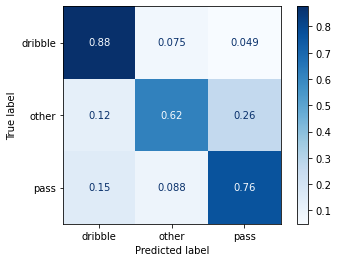

In [253]:
plot_confusion_matrix(pipe_svm, X_test, y_test, cmap='Blues', normalize='true')
plt.show()

- Between the classification report and confusion matrix, we can see that we get good performance for dribble classification, but not as good for passes or other. 
- The other category was expected to not perform as well due to the class imbalances.

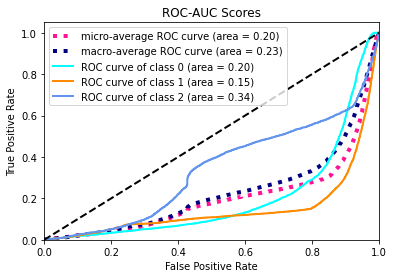

In [427]:
y_bin_test = label_binarize(y_test, classes = ['pass','dribble','other'])
n_classes = y_bin_test.shape[1]

y_score = pipe_svm.decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
lw = 2
# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Scores")
plt.legend(loc="best")
plt.show()

As mentioned above, the curves show a larger increase in the false positive rate, than would be ideal. 

# Classification - Team - End Zone

In [384]:
X_train, y_train, X_test, y_test = ppu.create_team_data('team_id',1475, modeling_train_df, modeling_test_df, 'end_pitch_zone')
numeric_features, categorical_features, drop_features = ppu.set_ct_mode('team-end')


ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    # ('passthrough', passthrough_features),
    ('drop', drop_features))


# define column transformer
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features),
    ('drop', 'drop', drop_features)])

estimator = Pipeline(steps=[('preprocessor', preprocessor),
                       ('dim_reducer', PCA()),
                       ('model', LinearRegression())], memory=cachedir)

In [59]:
# Define a parameter grid
param_grid_end = [
   
     {
        'model': [RandomForestClassifier(random_state=1, oob_score=True, n_jobs=-1)],
        'model__max_depth': list(range(2, 17, 2)),
        'model__max_features': [None, 'auto'],
        'model__n_estimators': list(range(80, 150, 20))}, 
    
     {
        'model': [xgb.XGBClassifier(random_state=1)],
        'model__max_depth': list(range(2, 5, 1)),
        'model__gamma': [0, 0.1, 0.5, 0.9],
        'model__eta': [0.01, 0.1, 0.3]
        },

]

# Instantiate a gridsearch
grid_end = GridSearchCV(estimator, param_grid_end, cv = 5, verbose = 2)
fitted_grid_end = grid_end.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END model=RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=1), model__max_depth=2, model__max_features=None, model__n_estimators=80; total time=   6.3s
[CV] END model=RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=1), model__max_depth=2, model__max_features=None, model__n_estimators=80; total time=   3.7s
[CV] END model=RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=1), model__max_depth=2, model__max_features=None, model__n_estimators=80; total time=   3.8s
[CV] END model=RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=1), model__max_depth=2, model__max_features=None, model__n_estimators=80; total time=   3.7s
[CV] END model=RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=1), model__max_depth=2, model__max_features=None, model__n_estimators=80; total time=   3.7s
[CV] END model=RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=1), 

In [177]:
grid_search_results_end = pd.DataFrame(fitted_grid_end.cv_results_)
grid_search_results_end.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__max_depth,param_model__max_features,param_model__n_estimators,param_model__eta,param_model__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
92,30.424726,0.650538,0.033494,0.001955,"XGBClassifier(base_score=None, booster=None, c...",3,NaN,NaN,0.3,0.1,"{'model': XGBClassifier(base_score=None, boost...",0.683054,0.684253,0.668665,0.673461,0.693046,0.680496,0.008574,1
90,35.460561,1.165587,0.029699,0.001232,"XGBClassifier(base_score=None, booster=None, c...",4,NaN,NaN,0.3,0,"{'model': XGBClassifier(base_score=None, boost...",0.692246,0.685052,0.661871,0.667466,0.695444,0.680416,0.013408,2
95,26.958471,0.399852,0.031620,0.001454,"XGBClassifier(base_score=None, booster=None, c...",3,NaN,NaN,0.3,0.5,"{'model': XGBClassifier(base_score=None, boost...",0.681055,0.680256,0.668665,0.673461,0.694644,0.679616,0.008788,3
91,19.683138,0.586587,0.032026,0.001173,"XGBClassifier(base_score=None, booster=None, c...",2,NaN,NaN,0.3,0.1,"{'model': XGBClassifier(base_score=None, boost...",0.677458,0.684652,0.667066,0.673062,0.692646,0.678977,0.008924,4
97,17.141578,0.201692,0.027977,0.001288,"XGBClassifier(base_score=None, booster=None, c...",2,NaN,NaN,0.3,0.9,"{'model': XGBClassifier(base_score=None, boost...",0.682254,0.687050,0.664668,0.674660,0.685851,0.678897,0.008325,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,1.209941,0.013858,0.032672,0.000936,"RandomForestClassifier(n_jobs=-1, oob_score=Tr...",2,auto,80,NaN,NaN,"{'model': RandomForestClassifier(n_jobs=-1, oo...",0.397282,0.417666,0.354516,0.367306,0.378497,0.383054,0.022287,96
0,4.213472,1.035617,0.034561,0.003887,"RandomForestClassifier(n_jobs=-1, oob_score=Tr...",2,None,80,NaN,NaN,"{'model': RandomForestClassifier(n_jobs=-1, oo...",0.325739,0.365308,0.271783,0.306155,0.308953,0.315588,0.030420,97
1,4.338059,0.064258,0.035688,0.000977,"RandomForestClassifier(n_jobs=-1, oob_score=Tr...",2,None,100,NaN,NaN,"{'model': RandomForestClassifier(n_jobs=-1, oo...",0.324940,0.362110,0.273381,0.305755,0.307754,0.314788,0.028941,98
2,4.997581,0.098873,0.038319,0.001049,"RandomForestClassifier(n_jobs=-1, oob_score=Tr...",2,None,120,NaN,NaN,"{'model': RandomForestClassifier(n_jobs=-1, oo...",0.325739,0.362110,0.272582,0.305356,0.306555,0.314468,0.029315,99


# Final Models

The final models were chosen based on their accuracy score or R2 for regression models against the test set. So the models need as a baseline to perform well at predicting the output of the team they were trained on. Further the models need to show a level of generalisation through regularisation. 

The hyper parameters were tweaked to reduce the training data set scores, while improving or only very minimally decreasing test scores.

For the classification models further analysis was done to validate their ability to predict a class as seen in the Next Action example above. 

<a id='finalvaep'></a>
### FINAL VAEP MODEL:

In [404]:
X_train, y_train, X_test, y_test = ppu.create_team_data('team_id',1475, modeling_train_df, modeling_test_df, 'vaep_value')
numeric_features, categorical_features, drop_features = ppu.set_ct_mode('team-vaep')

# define column transformed for pipeline
ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    # ('passthrough', passthrough_features),
    ('drop', drop_features))

# define column transformer for GridSearchCV
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features),
    ('drop', 'drop', drop_features)])

estimator = Pipeline(steps=[('preprocessor', preprocessor),
                       ('dim_reducer', PCA()),
                       ('model', LinearRegression())], memory=cachedir)

In [405]:
print('*** xGBoost Regressor - Depth 8 ***')
pipe = make_pipeline(ct, xgb.XGBRegressor(max_depth=8, gamma=0.01, reg_alpha=1.1, eta=0.1))
pipe.fit(X_train, y_train)
print('XGB Regressor Train Score: ', pipe.score(X_train, y_train))
print('XGB Regressor Test Score: ', pipe.score(X_test, y_test))
print(' ')

*** xGBoost Regressor - Depth 8 ***
XGB Regressor Train Score:  0.8406537986332749
XGB Regressor Test Score:  0.7623045325905606
 


In [406]:
column_names = (
    numeric_features 
    # + passthrough_features
    + ct.named_transformers_['onehotencoder'].get_feature_names_out().tolist())
# Put the variable names and their feature importances into a data frame
importances_df = pd.DataFrame({'Variable': column_names,
                               'Importance': pipe[1].feature_importances_})

importances_df.sort_values(by='Importance', ascending=False, inplace=True, ignore_index=True)

importances_df.head(5)

,Variable,Importance
0,type_name_shot,0.457126
1,result_name_success,0.134707
2,type_name_cross,0.043451
3,type_name_shot_freekick,0.023027
4,end_x,0.017588


**Model Explainability**

For predicting VAEP, we can see the 5 most important features are, whether the action was a shot, whether it was successful or whether it was a longer ball delivery such as a cross or freekick and finally the end location of the ball as measured by the x coordinate.

### FINAL xT MODEL

In [407]:
X_train, y_train, X_test, y_test = ppu.create_team_data('team_id',1475, modeling_xt_train_df, modeling_xt_test_df, 'xT_value')

numeric_features, categorical_features, drop_features = ppu.set_ct_mode('team-xt')

# pipeline column transformer
ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    # ('passthrough', passthrough_features),
    ('drop', drop_features))

# define gridsearch column transformer
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features),
    ('drop', 'drop', drop_features)])

estimator = Pipeline(steps=[('preprocessor', preprocessor),
                       ('dim_reducer', PCA()),
                       ('model', LinearRegression())], memory=cachedir)

In [408]:
print('*** xGBoost Regressor - Depth 5 Optimised ***')
pipe = make_pipeline(ct, xgb.XGBRegressor(max_depth=5, reg_lambda=200))
pipe.fit(X_train, y_train)
print('XGB Regressor Train Score: ', pipe.score(X_train, y_train))
print('XGB Regressor Test Score: ', pipe.score(X_test, y_test))
print(' ')

*** xGBoost Regressor - Depth 5 Optimised ***
XGB Regressor Train Score:  0.9265065158190492
XGB Regressor Test Score:  0.8085949010492468
 


In [409]:
column_names = (
    numeric_features 
    # + passthrough_features
    + ct.named_transformers_['onehotencoder'].get_feature_names_out().tolist())
# Put the variable names and their feature importances into a data frame
importances_df = pd.DataFrame({'Variable': column_names,
                               'Importance': pipe[1].feature_importances_})

importances_df.sort_values(by='Importance', ascending=False, inplace=True, ignore_index=True)

importances_df.head(5)

,Variable,Importance
0,type_name_cross,0.230911
1,end_pitch_zone_zone_8,0.100993
2,start_pitch_zone_zone_8,0.063345
3,x_dif,0.046887
4,end_x,0.044581


**Model Explainability**

For xT we can see that start and ending in zone * are important features, but not as important as action type being a cross - maybe due to crosses being longer ball delivery option moving the ball into zone 8. Therefore the top 3 features making sense together. 

To further back this view up we see that x_dif is also in the top 5 - meaning that longer balls increase the value of xT likely due to the higher likelyhood for the ball to end in a dangerous zone of the pitch, especially as end_x is also in the top 5 for this model. 

### FINAL NEXT ACTION MODEL

In [428]:
X_train, y_train, X_test, y_test = ppu.create_team_data('team_id',1475, modeling_train_df, modeling_test_df, 'type_name_encoded')

numeric_features, categorical_features, drop_features = ppu.set_ct_mode('team-action')

ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    # ('passthrough', passthrough_features),
    ('drop', drop_features))

# define column transformer

cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features),
    ('drop', 'drop', drop_features)])

estimator = Pipeline(steps=[('preprocessor', preprocessor),
                       ('dim_reducer', PCA()),
                       ('model', LinearRegression())], memory=cachedir)

In [430]:
print('*** xGBoost Classifier ***')
pipe = make_pipeline(ct, xgb.XGBClassifier(max_depth=3, eta=0.3, gamma=0.01))
pipe.fit(X_train, y_train)
print('XGB Train Score: ', pipe.score(X_train, y_train))
print('XGB Test Score: ', pipe.score(X_test, y_test))
print(' ')

*** xGBoost Classifier ***
[21:23:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB Train Score:  0.872501998401279
XGB Test Score:  0.8036798612062275
 


In [412]:
roc_auc_score(y_test, pipe.predict_proba(X_test), multi_class='ovo')

0.9214789707522385

- Here we can already see a better score than in the SVM model - on top of the better accuracy scores.

              precision    recall  f1-score   support

     dribble       0.80      0.91      0.85      8378
       other       0.74      0.63      0.69      4117
        pass       0.83      0.79      0.81      9408

    accuracy                           0.80     21903
   macro avg       0.79      0.78      0.78     21903
weighted avg       0.80      0.80      0.80     21903



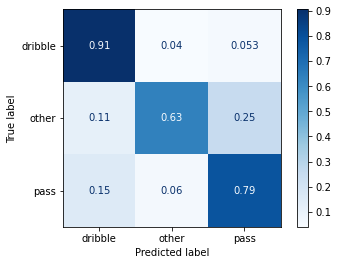

In [431]:
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)

print(classification_report(y_test, y_pred))

plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', normalize='true')
plt.show()

- From the classification report and confusion matrix, we also see better performance in predicting the 3 classes. However we again see a similar pattern where dribbles have a far greater performance than the other 2 categories. 

This model will likely need further iteration to refine and improve the outcomes. Either through tuning or up/down sampling the input data. 

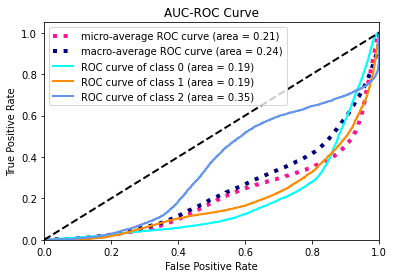

In [433]:
y_bin_test = label_binarize(y_test, classes = ['pass','dribble','other'])
n_classes = y_bin_test.shape[1]

y_score = pipe.predict_proba(X_test)
# y_score = pipe_svm.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
lw = 2
# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve")
plt.legend(loc="best")
plt.show()

Like with the SVM model again we see that the curves are not showing ideal performance and the rate of false positives is too high - which further backs the view that this model will need further research.

In [414]:
column_names = (
    numeric_features 
    # + passthrough_features
    + ct.named_transformers_['onehotencoder'].get_feature_names_out().tolist())
# Put the variable names and their feature importances into a data frame
importances_df = pd.DataFrame({'Variable': column_names,
                               'Importance': pipe[1].feature_importances_})

importances_df.sort_values(by='Importance', ascending=False, inplace=True, ignore_index=True)

importances_df.head(5)

,Variable,Importance
0,n-1_type_name_encoded_dribble,0.199941
1,n-1_same_team_False,0.150945
2,n-1_type_name_encoded_pass,0.043632
3,n-1_result_name_success,0.040079
4,n-2_type_name_encoded_dribble,0.030164


**Model Explainability**

The key determinants of the next action in this model - are the previous 2 actions. Especially if those were dribbles. Interestingly whether the previous action was made by the other team ranked highly in this model, perhaps suggesting that a pass or dribble follows a period of possesion by the other team(which is quite an expected outcome). 

We also see that prior action outcome was also importance alongside whether they were passes. 

### FINAL END ZONE MODEL

In [434]:
X_train, y_train, X_test, y_test = ppu.create_team_data('team_id',1475, modeling_train_df, modeling_test_df, 'end_pitch_zone')
numeric_features, categorical_features, drop_features = ppu.set_ct_mode('team-end')


ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    # ('passthrough', passthrough_features),
    ('drop', drop_features))


# define column transformer
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features),
    ('drop', 'drop', drop_features)])

estimator = Pipeline(steps=[('preprocessor', preprocessor),
                       ('dim_reducer', PCA()),
                       ('model', LinearRegression())], memory=cachedir)

In [435]:
print('*** xGBoost Classifier ***')
pipe = make_pipeline(ct, xgb.XGBClassifier(max_depth=3, eta=0.3, gamma=0.01))
pipe.fit(X_train, y_train)
print('XGB Train Score: ', pipe.score(X_train, y_train))
print('XGB Test Score: ', pipe.score(X_test, y_test))
print(' ')

*** xGBoost Classifier ***
[21:30:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB Train Score:  0.8621902478017586
XGB Test Score:  0.7228690133771629
 


In [436]:
y_pred_end = pipe.predict(X_test)
y_proba_end = pipe.predict_proba(X_test)

In [437]:
roc_auc_score(y_test, y_proba_end, multi_class='ovr')

0.9625525120169188

In [438]:
print(classification_report(y_test, y_pred_end))

              precision    recall  f1-score   support

      zone_1       0.69      0.63      0.66      1589
      zone_2       0.64      0.70      0.67      2231
      zone_3       0.69      0.67      0.68      1730
      zone_4       0.74      0.76      0.75      3383
      zone_5       0.65      0.57      0.61      2486
      zone_6       0.72      0.76      0.74      3441
      zone_7       0.78      0.78      0.78      2293
      zone_8       0.79      0.73      0.76      2213
      zone_9       0.78      0.81      0.80      2537

    accuracy                           0.72     21903
   macro avg       0.72      0.71      0.72     21903
weighted avg       0.72      0.72      0.72     21903



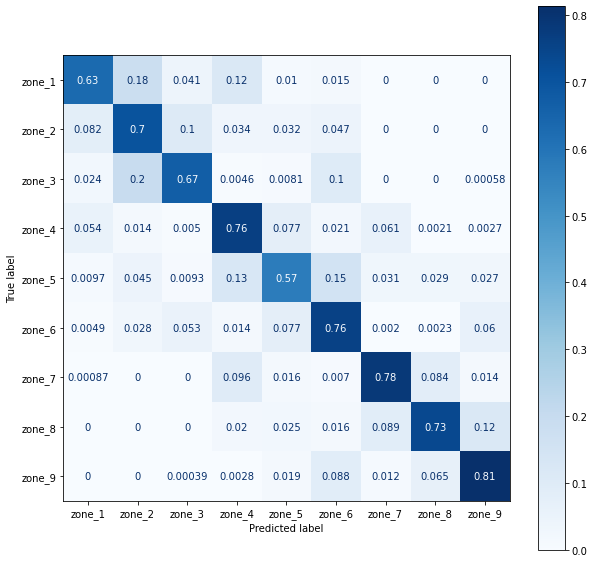

In [439]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', normalize='true', ax=ax)
plt.show()

- From the classification report and the confusion matrix we see that performance varies between different end zones. Perhaps expected as we didnt have perfectly balanced end zones in the input data.
- Zone 5 performing the worst. 
- We care about zones 7,8,9 the most as those are the high value zones, so we could focus on those - or recut the dataset to focus on those 3 zones vs the rest in a future iteration.

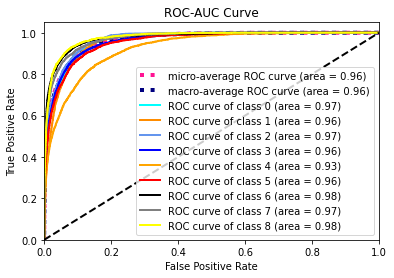

In [440]:
y_bin_test = label_binarize(y_test, classes = ['zone_1','zone_2','zone_3', 'zone_4', 'zone_5', 'zone_6', 'zone_7', 'zone_8', 'zone_9'])
n_classes = y_bin_test.shape[1]

y_score = pipe.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
lw = 2
# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "blue", "orange", "red","black", "gray", "yellow"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend(loc="best")
plt.show()

- In this model we have a nearly ideal ROC-AUC curve - Showing that we have good performance on getting true positives for all classes.

- However based on the classification report and confusion matrix, the 2 validation methods don't tell a consistent story - and would like need to review how this model is built in a future iteration.

In [441]:
column_names = (
    numeric_features 
    # + passthrough_features
    + ct.named_transformers_['onehotencoder'].get_feature_names_out().tolist())
# Put the variable names and their feature importances into a data frame
importances_df = pd.DataFrame({'Variable': column_names,
                               'Importance': pipe[1].feature_importances_})

importances_df.sort_values(by='Importance', ascending=False, inplace=True, ignore_index=True)

importances_df.head(5)

,Variable,Importance
0,start_pitch_zone_zone_9,0.181271
1,start_pitch_zone_zone_7,0.114634
2,start_pitch_zone_zone_1,0.111615
3,start_pitch_zone_zone_6,0.104527
4,start_pitch_zone_zone_5,0.064072


**Model Explainability**

For this model, explainability tells a very simple story - where the ball starts is the best indicator of where it will end up. 

The only interesting insight here is that zone 1 ranks so highly given it's not the most frequented area on the pitch.